In [1]:
import paths
import yaml
import os
import copy
import h5py
import GPy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
from cklemap.sdfs.darcy import DarcyExp
from cklemap.sdfs.dasa import DASAExpKL, DASAExpKLAMPS
import cklemap.ckli.mapest as mapest

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
amps = True
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 25
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
res_fac = 1
resolution = '4x'
resolution_ref = '1x'
resolution_iYobs = '16x'
lsq_method = 'trf'
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_ref_filename= data_path + f'geom/geom_{resolution_ref}.mat'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'yref/conduct_log_RF1_{resolution_ref}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'
yobs_fine_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
ref = f'Yref=RF1_interpolated_{resolution}'

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
if resolution_ref != resolution:
    geom_ref = GeomMRST(geom_ref_filename)
else:
    geom_ref = geom
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]
patches_ref = [mpatches.Polygon(v, closed=True) for v in geom_ref.nodes.coords.T[geom_ref.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref_orig = f.get('conduct_log')[:].ravel() - Yfac

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref + Yfac, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
geom_fine = GeomMRST(geom_fine_filename)

if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
elif os.path.exists(yobs_fine_filename):
    print(f"iYobs set read from file {yobs_fine_filename} and randomly selected nearby cell")
    iYobs_fine = np.load(yobs_fine_filename)
    geom_fine = GeomMRST(geom_ref_filename)
    iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
    np.save(yobs_filename, iYobs)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs_ref = np.array([geom_ref.cellsContain(geom_fine.cells.centroids.T[iYobs[t]]) for t in range(num_trials)])
iYlearn = iYobs_ref
Ylearn = np.array([Yref_orig[iYlearn[t]] for t in range(num_trials)])

iYobs set read from file ../data/yobs/yobs_25_4x.npy
iYobs.shape=(10, 25)
[[ 926 1306 1445 1448 1682 1785 1834 1948 2233 2607 2696 3034 3045 3355
  3415 3431 3536 3590 3602 4124 4457 4629 5355 5776 5862]
 [  90  584  733  995 1210 1245 1746 1819 1980 2135 2400 2461 2692 2783
  3224 3367 3733 4020 4039 4152 4345 4900 4970 5295 5456]
 [ 360  386  464  611  633  638 1079 1313 1358 1571 1604 2120 2164 2285
  2603 3237 3766 3926 4143 4397 4635 4660 4778 5219 5777]
 [ 430  450  659  681 1163 1328 1348 1620 2188 2230 2278 2369 2482 2705
  2792 2825 3529 3868 3931 4327 4523 5046 5151 5293 5581]
 [ 173  220  800 1096 1293 1355 1507 1516 2254 2291 2607 2886 3189 4107
  4271 4296 4573 4939 4964 5502 5640 5741 5815 5829 5868]
 [  93  819  887  908 1002 2196 2300 2310 2382 3057 3268 3359 3420 3481
  4065 4593 5026 5139 5154 5161 5167 5259 5397 5575 5658]
 [ 208  403  475  873 1945 1997 2463 2595 3137 3290 3299 3398 3412 3893
  3902 4217 4430 4458 4516 4625 5238 5473 5583 5685 5720]
 [ 346  449  568

In [9]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

solve_time = np.zeros((num_trials))
obj_time = np.zeros((num_trials))
jac_time = np.zeros((num_trials))
dLdp_time = np.zeros((num_trials))
grad_time = np.zeros((num_trials))

Yref = np.zeros((num_trials, Nc))
CYref = np.zeros((num_trials, Nc, Nc))
Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))

Yest = np.zeros((num_trials, Nc))

In [10]:
for t in range(num_trials):
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom_ref.cells.centroids[:, iYlearn[t]].T, Ylearn[t, :, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom_ref.cells.centroids.T, Yref_orig[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Yref[t], CYref[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   3.367956e+01   3.316639e+02 
    00s03  0012   2.775735e+01   6.323035e-02 
    00s07  0021   2.742358e+01   1.593546e-02 
    00s09  0027   2.741942e+01   3.484360e-04 
    00s11  0033   2.741919e+01   2.658093e-07 
    00s12  0039   2.741919e+01   9.157192e-06 
Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   4.051866e+01   2.071039e+02 
    00s02  0006   3.870734e+01   1.068423e+01 
    00s03  0009   3.759412e+01   1.058114e-01 
    00s05  0015   3.757146e+01   2.962922e-12 
Runtime:     00s05
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0009   2.192664e+01   1.278774e-01 
    00s05  0018   2.157136e+01   2.195408e-03 
    00s07  0025   2.156198e+01   2.531796e-07 
    00s11  

In [11]:
np.savetxt(results_path + f'Yref/Yref_{NYlearn=}_{ref}.txt', Yref)

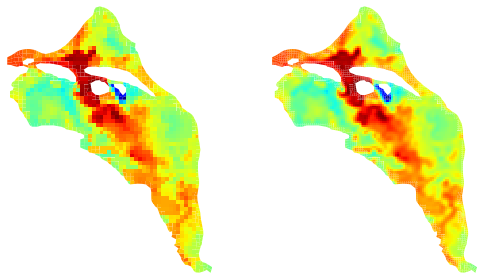

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_patch(patches_ref, Yref_orig + Yfac, fig, ax[0], None, 'Yref', 0, 12)
plot_patch(patches, Yref[0] + Yfac, fig, ax[1], None, 'Yref_4x', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_{resolution_ref=}_NY={NYobs}_{resolution}.pdf', dpi=300)

In [13]:
# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
Nuobs = iuobs.size

#prob = DarcyExp(TPFA(geom, bc), None)
prob = DarcyExp(TPFA(geom, bc), iuobs, amps, None)

uref = np.array([prob.solve(Yref[t]) for t in range(num_trials)])
uobs = uref[:, iuobs]


In [14]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_cklmap_h1reg_{amps=}_{ref}'
print(exp)

NY=25_Nu=408_NYlearn=25_NYxi=1000_gamma=1e-06_cklmap_h1reg_amps=True_Yref=RF1_interpolated_4x


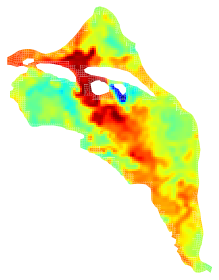

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_patch(patches, Yref[0] + Yfac, fig, ax, None, 'Yref', 0, 12, False)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_{NYlearn=}_{ref}.pdf', dpi=300)

In [16]:
""" Yest = np.loadtxt(results_path + f'YMAP/YMAP_{exp}.txt')

fig, ax = plt.subplots(figsize=(4, 4))
plot_patch(patches, np.abs(Yest[0] - Yref[0]), fig, ax, None, '|Yest_CKLEMAP - Yref|', 0, 6, False)
fig.tight_layout()
fig.savefig(figures_path + f'Ydiff_CKLEMAP/Ydiff_CKLEMAP_{exp}.pdf', dpi=300) """

" Yest = np.loadtxt(results_path + f'YMAP/YMAP_{exp}.txt')\n\nfig, ax = plt.subplots(figsize=(4, 4))\nplot_patch(patches, np.abs(Yest[0] - Yref[0]), fig, ax, None, '|Yest_CKLEMAP - Yref|', 0, 6, False)\nfig.tight_layout()\nfig.savefig(figures_path + f'Ydiff_CKLEMAP/Ydiff_CKLEMAP_{exp}.pdf', dpi=300) "

In [17]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[t, iYlearn]
    Yobs[t] = Yref[t, iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   4.432021e+01   7.823108e+01 
    00s02  0006   4.015127e+01   2.762610e+01 
    00s03  0011   3.902425e+01   1.305225e-04 
    00s04  0014   3.902425e+01   1.548118e-08 
Runtime:     00s04
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   5.228924e+01   2.239167e+03 
    00s02  0008   3.635757e+01   1.876592e+00 
    00s04  0015   3.573687e+01   4.200295e-09 
    00s04  0017   3.573687e+01   1.122222e-11 
Runtime:     00s04
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0010   4.231978e+01   1.222433e+00 
    00s03  0013   4.229565e+01   1.544379e-03 
    00s05  0017   4.229555e+01   1.385886e-11 
Runtime:     00s05
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtim

In [18]:
# PICKLE models
Ym = Ypred
CYm = CYpred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref[t]) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref[t]) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.18675249 0.22327523 0.1952683  0.18099931 0.17460895 0.200323
 0.1873775  0.17569214 0.17486443 0.17785063]
GPR	Infinity error: [ 9.38070394 10.70225609  7.14443372  7.62353645  7.41113839  7.95214891
  9.2937589   8.98768863  8.20450055  6.24087739]


In [19]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [15.51472739 15.65827462 15.2488658  14.89364156 15.39168323 15.8439152
 15.56053709 15.24480054 14.56471954 14.75617277] s


In [20]:
# CKL-MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs[t], iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        #prob.setup_amps(iuobs)
        dasa = DASAExpKLAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs, Ym[t], PsiY[t])
        #dasa = DASAExpKLAMPS(loss.val, loss.grad_u, loss.grad_Y, prob.partial_solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t], prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs)
    else:
        dasa = DASAExpKL(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u,
                         prob.residual_sens_Y, (Nuobs + NYobs + Ninf, NYxi), Nuobs, Ym[t], PsiY[t], prob.adj_solve)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKLEMAP status: {MAP_status}, message: {sol.message}')

    solve_time[t] = dasa.solve_time
    obj_time[t] = dasa.obj_time
    jac_time[t] = dasa.jac_time
    dLdp_time[t] = dasa.dLdp_time
    grad_time[t] = dasa.grad_time

rel_errors[:, 2] = np.array([rl2e(Yest[t], Yref[t]) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest[t], Yref[t]) for t in range(num_trials)])

print(f"CKLEMAP: {timings[:, 4]} s")
print(f"CKLEMAP relative L2 error: {rel_errors[:, 2]}")
print(f"CKLEMAP absolute infinity error: {abs_errors[:, 2]}")
print(f"CKLEMAP solve time: {solve_time}")
print(f"CKLEMAP objective time: {obj_time}")
print(f"CKLEMAP Jacobian time: {jac_time}")
print(f"CKLEMAP dLdp time: {dLdp_time}")
print(f"CKLEMAP grad time: {grad_time}")


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1846e+02                                    7.14e+02    
       1              2         1.5908e+02      6.59e+02       1.00e+00       2.39e+02    
       2              3         2.4270e+01      1.35e+02       2.00e+00       2.19e+01    
       3              4         4.6612e+00      1.96e+01       4.00e+00       1.04e+01    
       4              5         8.7302e-01      3.79e+00       8.00e+00       4.92e+00    
       5              6         5.4105e-01      3.32e-01       1.60e+01       7.36e+00    
       6              7         1.3417e-01      4.07e-01       1.60e+01       3.77e+00    
       7              9         1.5248e-02      1.19e-01       8.00e+00       5.37e-01    
       8             11         9.9924e-03      5.26e-03       4.00e+00       2.12e-01    
       9             13         8.5324e-03      1.46e-03       2.00e+00       5.43e-02    

In [21]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest)

In [22]:
t = 0

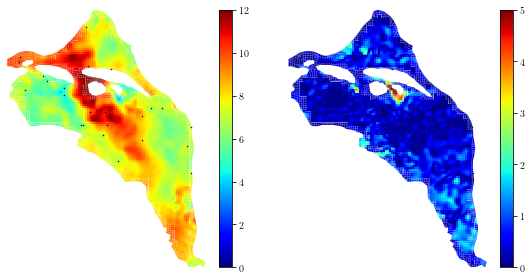

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_patch(patches, Yest[t] + Yfac, fig, ax[0], geom.cells.centroids[:, iYobs[t]], 'Yest_CKLEMAP', 0, 12, True)
plot_patch(patches, np.abs(Yest[t] - Yref[t]), fig, ax[1], geom.cells.centroids[:, iYobs[t]], '|Yest_CKLEMAP - Yref|', 0, 5, True)

fig.tight_layout()

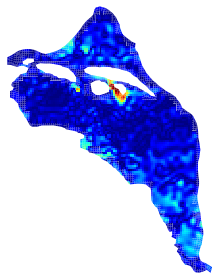

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, np.abs(Yest[t] - Yref[t]), fig, ax, None, '|Yest_CKLEMAP - Yref|', 0, 5, False)

fig.tight_layout()
fig.savefig(figures_path + f'Ydiff_CKLEMAP/Ydiff_CKLEMAP_{exp}.pdf', dpi=300)